In [1]:
import pandas as pd
import numpy as np
import os
import importlib
import data_pipeline as dp
import assets
import modeling

importlib.reload(dp)
importlib.reload(assets)
importlib.reload(modeling)
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from scipy import stats
import pandas as pd
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
import optuna
import pandas as pd
from sklearn.model_selection import train_test_split


import warnings
warnings.filterwarnings("ignore")

C:\Users\almog\AppData\Local\Temp\ipykernel_29928\224222497.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
c:\Users\almog\anaconda3\envs\ml\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from scipy.stats import chi2_contingency

def calc_binary_corr(features, target: str, df) -> pd.DataFrame:
    """
    Calculates the point biserial correlation between a binary feature and a quantitative target feature.
    
    Args:
        features (list): List of binary features.
        target (str): Name of the target feature.
        df (pd.DataFrame): DataFrame containing the features and target.
        
    Returns:
        pd.DataFrame: DataFrame with the correlation values between the binary features and the target feature.
    """
    correlations = []
    
    for feature in features:
        correlation = stats.pointbiserialr(df[feature], df[target]).correlation
        correlations.append(correlation)
        
    data_co = pd.DataFrame({"feature": features, "correlations": correlations})
    return data_co

def cat_segnificance(data: pd.DataFrame, features, target) -> pd.DataFrame:
    """
    Calculates the significance of categorical features with respect to a target feature using the chi-square test.
    
    Args:
        data: DataFrame containing the features and target.
        features: List of categorical features.
        target: Name of the target feature.
        
    Returns:
        pd.DataFrame: DataFrame with the significant and non-significant features, along with their p-values.
    """
    val = []
    seg = []
    non_seg = []
    
    for i in features:
        CrosstabResult = pd.crosstab(index=data[target], columns=data[i])
        _, p, _, _ = chi2_contingency(CrosstabResult)
        alpha = 0.05
        
        if p <= alpha:
            seg.append(True)
            val.append(p)
        else:
            seg.append(False)
            val.append(p)
            non_seg.append(i)
            
    return pd.DataFrame({"Significant": seg, "p_val": val, "col": features}), non_seg

def corr_heatmap(correlation_matrix: pd.DataFrame, figsize: tuple = (25, 25)):
    """
    Plots a heatmap of the correlation matrix.
    
    Args:
        correlation_matrix (pd.DataFrame): DataFrame containing the correlation values.
        figsize (tuple, optional): Figure size. Defaults to (25, 25).
    """

    f, ax = plt.subplots(figsize=figsize)
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(correlation_matrix, cmap=cmap, vmax=1, vmin=-1, center=0,
                square=True, linewidths=.5)
    plt.show()

def select_features_quantative(x_train: pd.DataFrame, y_train: pd.Series, k: int) -> pd.DataFrame:
    """
    Selects the top k quantitative features using the f_classif score.
    
    Args:
        x_train: DataFrame containing the training data.
        y_train: Series containing the target labels.
        k: Number of features to select.
        
    Returns:
        pd.DataFrame: Transformed training data with the selected "K" features.
        selector: Feature selector object to get the importances.
    """

    selector = SelectKBest(f_classif, k=k)
    x_train_dim = selector.fit_transform(x_train, y_train)

    return x_train_dim, selector

In [3]:
class optimizer:
    def __init__(self, data, target, data_val, target_val, n_trials, model):
        self.data = data
        self.target = target
        self.data_val = data_val
        self.target_val = target_val
        self.n_trials = n_trials
        self.model = model

    def get_params(self, trial):
        if self.model == "gb":
            param = {
                'tree_method':'gpu_hist',
                'max_depth': trial.suggest_int('max_depth', 1, 9),
                'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
                'n_estimators': trial.suggest_int('n_estimators', 50, 5000),
                'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
                'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
            }
        elif self.model == "rf":
            param = {
                'n_estimators': trial.suggest_int('n_estimators', 50, 5000),
                'max_depth': trial.suggest_int('max_depth', 1, 15),
                'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
                'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
                'bootstrap': trial.suggest_categorical('bootstrap', [True]),
            }
        elif self.model == "et":
            param = {
                "min_samples_split" : trial.suggest_int('min_samples_split', 2, 12),
                "n_estimators" : trial.suggest_int('n_estimators', 50, 5000),
                "max_depth" : trial.suggest_int('max_depth', 3, 15),
                "max_leaf_nodes" : trial.suggest_int('max_leaf_nodes', 15, 25),
                'bootstrap': trial.suggest_categorical('bootstrap', [True]),
            }

        return param
        
    def objective(self, trial):
        
        train_x, test_x, train_y, test_y = train_test_split(self.data, self.target, test_size=0.2, shuffle = True)
        
        if self.model == "gb":
            model = XGBClassifier(**self.get_params(trial))
            model.fit(train_x,train_y,eval_set=[(test_x,test_y)],early_stopping_rounds=100,verbose=False)
        elif self.model == "rf":
            model = RandomForestClassifier(**self.get_params(trial))
            model.fit(train_x,train_y)
        elif self.model == "et":
            model = ExtraTreesClassifier(**self.get_params(trial))
            model.fit(train_x,train_y)

        preds = model.predict(test_x)
        acc = accuracy_score(test_y, preds)
        return acc

    def optimize(self):
        study = optuna.create_study(direction='maximize')
        study.optimize(self.objective, n_trials=self.n_trials)
        print('Number of finished trials:', len(study.trials))
        print('Best trial:', study.best_trial.params)
        
        return study.best_trial.params
    
    def train_best(self):

        x_train, x_val, y_train, y_val = self.data, self.data_val, self.target, self.target_val
        best_params = self.optimize()

        if self.model == "gb":
            model = XGBClassifier(**best_params)
            model.fit(x_train, y_train)
        elif self.model == "rf":
            model = RandomForestClassifier(**best_params)
            model.fit(x_train, y_train)
        elif self.model == "et":
            model = ExtraTreesClassifier(**best_params)
            model.fit(x_train, y_train)

        preds = model.predict(x_val)
        val_acc = accuracy_score(y_val, preds)
        cross_val_scores = cross_val_score(model, x_train, y_train, cv=10, n_jobs=-1, scoring='accuracy')

        conf = confusion_matrix(y_val, preds)

        return model, val_acc, cross_val_scores, conf

In [4]:

import pandas as pd
from sklearn.model_selection import train_test_split

def get_cat_feats(data):
    """
    Get a list of names of categorical features from the dataset.

    Args:
        data: The dataset to be used

    Returns:
        cat_cols: list of categorical feature names.
    """
    columns = data.columns
    wild_cols = columns[columns.str.contains("Wilderness_Area")]
    soil_cols = columns[columns.str.contains("Soil_Type")]
    cat_cols = list(wild_cols) + list(soil_cols)

    return cat_cols

def drop_features(data, features):
    """
    Drop specified features from the dataset.

    Args:
        data: The dataset to be used in training or testing.
        features: list of features to be dropped.

    Returns:
        data: The dataset after dropping the specified features.
    """
    data = data.drop(features, axis=1)
    return data

def preprocess(data, features_drop, target=None, kind="train"):
    """
    Preprocess the given dataset by dropping features and transforming the target variable.

    Args:
        data: The dataset.
        features_drop: List of features to be dropped.
        target: The target variable.
        kind: The kind of data (train or test).

    Returns:
        data: The preprocessed dataset.
        target: The preprocessed target variable (if kind is train).
    """
    data = drop_features(data, features_drop)

    if kind == "train":
        target -= 1
        target = target.astype("category")
        return data, target
    else:
        return data

def load_data(path: str = './dataset/') -> tuple:
    """
    Load the train and test data from CSV files.

    Args:
        path: Path to the directory containing the dataset.

    Returns:
        train_data: The train dataset.
        test_data: The test dataset.
    """
    train_data = pd.read_csv(path + 'train.csv')
    test_data = pd.read_csv(path + 'test.csv')

    return train_data, test_data

def split_data(data_x, data_y):
    """
    Split the dataset into train and test sets.

    Args:
        data_x: The input features.
        data_y: The target variable.

    Returns:
        x_train, x_test, y_train, y_test
    """
    x_train, x_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.2, random_state=42)

    return x_train, x_test, y_train, y_test


def get_processed_data(features_to_drop):
    """
    Get the processed data for training and testing.

    Args:
        features_to_drop: List of features to be dropped.

    Returns:
        x_train, x_test, y_train, y_test
        test_id: id of the test data to be submitted to Kaggle.
    """
    train_data, test_data = load_data(path='./dataset/')
    test_id = test_data["Id"]

    train_data_dropped = train_data.drop("Cover_Type", axis=1)

    train_y = train_data["Cover_Type"]

    train_data, target = preprocess(train_data_dropped, features_to_drop, train_y)
    test_data = preprocess(test_data, features_to_drop, kind="test")

    x_train, x_test, y_train, y_test = split_data(train_data, target)

    return x_train, x_test, y_train, y_test, test_id

In [16]:
def plot_legend(ax):
    ax.spines[:].set_visible(False)
    ax.set_yticks([])
    ax.bar_label(ax.containers[0], fmt='%.0f')
    ax.xaxis.set_tick_params(length=0,labelbottom=True)

In [17]:
features_to_drop = ['Id']

(x_train, 
 x_test, 
 y_train, 
 y_test, 
 test_id) = get_processed_data(features_to_drop)

In [6]:
display(x_train.head())

train_data = x_train.copy()
train_data.loc[:, "Cover_Type"] = y_train

Elevation  Aspect  Slope  Horizontal_Distance_To_Hydrology  \
4679        2364       3     30                               404   
6634        2883      62     10                               365   
11459       2972     162     15                               108   
15053       2395     349     32                                95   
8222        3244      64     21                               108   

       Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
4679                              152                             1107   
6634                               51                              690   
11459                              20                             4195   
15053                              27                              607   
8222                               25                             2521   

       Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
4679             166             169            129   
6634             229             218            121   
11459            233             243            136   
15053            145             169            150   
8222             234             194             82   

       Horizontal_Distance_To_Fire_Points  ...  Soil_Type31  Soil_Type32  \
4679                                   95  ...            0            0   
6634                                 1405  ...            0            0   
11459                                5280  ...            0            0   
15053                                 875  ...            0            0   
8222                                  408  ...            0            0   

       Soil_Type33  Soil_Type34  Soil_Type35  Soil_Type36  Soil_Type37  \
4679             0            0            0            0            0   
6634             0            0            0            0            0   
11459            0            0            0            0            0   
15053            0            0            0            0            0   
8222             0            0            0            0            0   

       Soil_Type38  Soil_Type39  Soil_Type40  
4679             0            0            0  
6634             0            0            0  
11459            0            0            0  
15053            0            0            0  
8222             0            1            0  

[5 rows x 54 columns]

In [ ]:
x_quant = x_train[[x for x in list(x_train.columns) if x not in  cat_cols]]

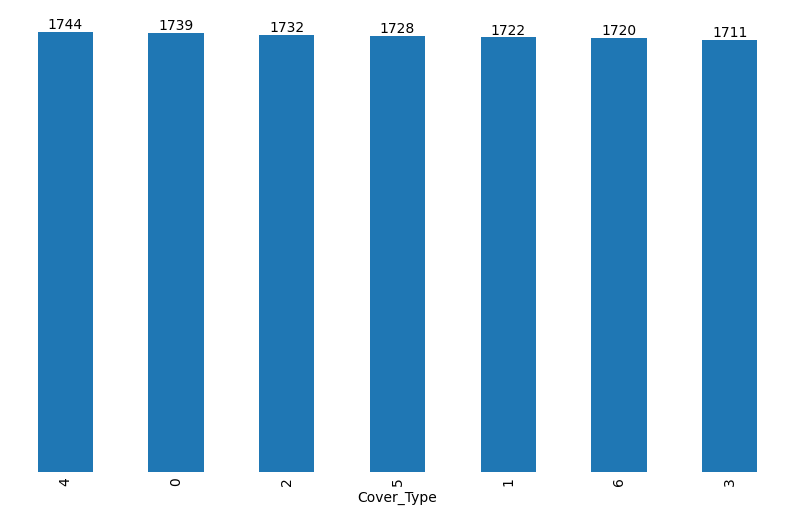

In [19]:
ax = y_train.value_counts().plot(kind='bar', figsize=(10, 6))

plot_legend(ax)

In [ ]:
_, selector = select_features_quantative(x_quant, y_train, len(x_quant.columns))

cols = {"Scores" : selector.scores_, "P_values" : selector.pvalues_}

scores = pd.DataFrame(cols, index = x_quant.columns)

In [ ]:
scores[scores["P_values"] < 0.05].sort_values("Scores", ascending = False)

Scores       P_values
Elevation                           13072.607446   0.000000e+00
Horizontal_Distance_To_Roadways       982.078742   0.000000e+00
Horizontal_Distance_To_Fire_Points    603.788199   0.000000e+00
Hillshade_9am                         311.077033   0.000000e+00
Horizontal_Distance_To_Hydrology      306.930772   0.000000e+00
Slope                                 234.629824  1.356237e-284
Hillshade_3pm                         157.017579  9.691643e-193
Hillshade_Noon                         89.013656  1.077488e-109
Vertical_Distance_To_Hydrology         63.439637   7.176110e-78
Aspect                                 41.314939   3.898746e-50

In [ ]:
non_seg_cols

features_to_drop = ['Soil_Type7', 'Soil_Type8', 'Soil_Type15', 'Soil_Type25', 'Id']

(x_train, 
 x_test, 
 y_train, 
 y_test, 
 test_id) = get_processed_data(features_to_drop)

As obvious here the only features with non significant contribution from the categorical features are the Soil_type7, Soil_Type25, Soil_type15 and Soild_Type8

In [ ]:
train_data[non_seg_cols].sum()

Soil_Type7     0
Soil_Type8     1
Soil_Type15    0
Soil_Type25    1
dtype: int64

In [13]:
train_data_drop = train_data.drop(non_seg_cols, axis=1)
non_cat_cols = set(train_data_drop.columns).difference(set(cat_cols))
train_data_non_cat = train_data_drop[list(non_cat_cols)]

As obvious here, those 4 features have only 1 value marked as 1 so they are not useful to the model at all. I will drop them from the data

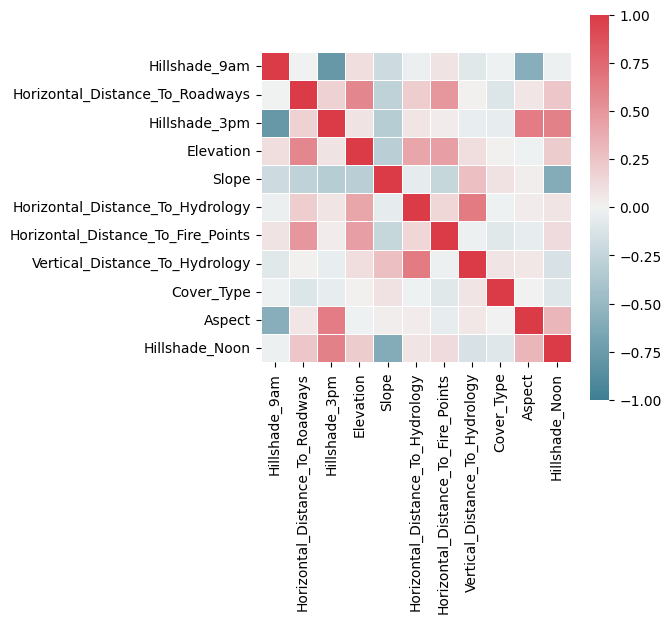

In [14]:
corr = train_data_non_cat.corr()
assets.corr_heatmap(corr, figsize=(5, 5))

There is an obvious linear correlation between different features, but let's remember that pearson' correlation shows the linear component, so I will plot the features to see if there is an obvious non-lineear correlation.

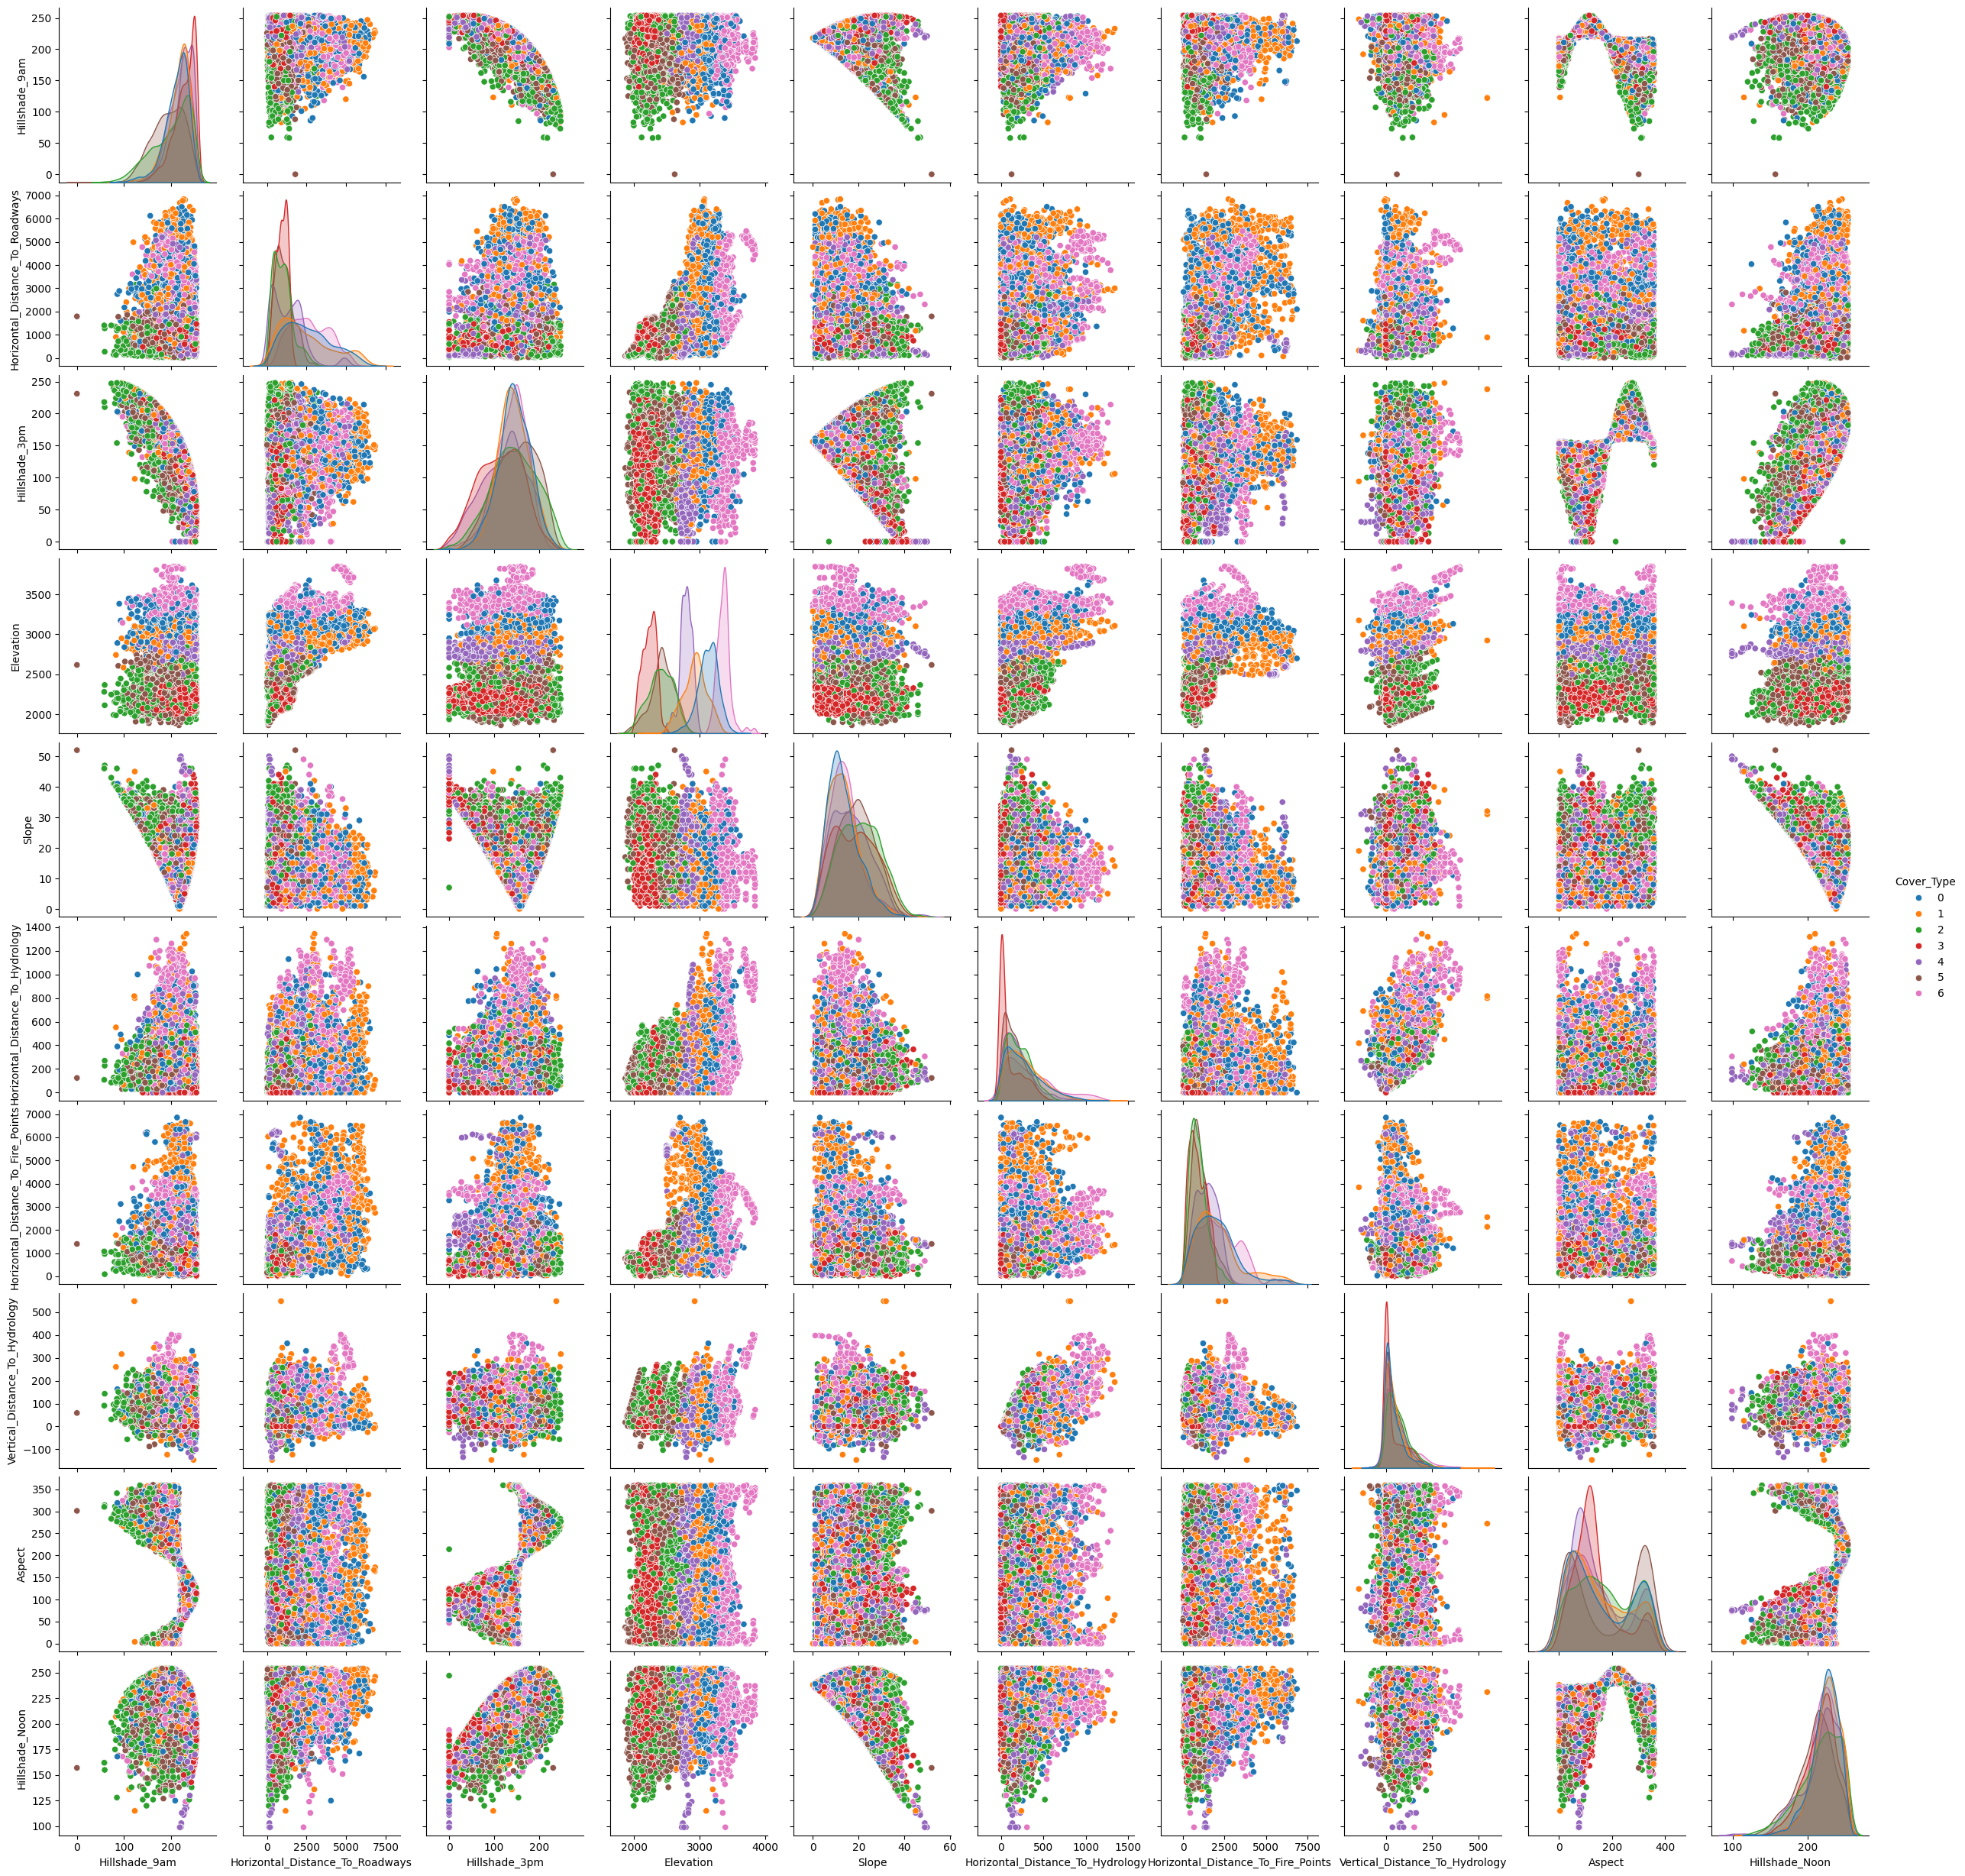

In [15]:
train_data_non_cat.loc[:, "Cover_Type"] = train_data_non_cat["Cover_Type"].astype("category")
sns.pairplot(train_data_non_cat, hue="Cover_Type", diag_kind="kde")

Let's now focus on some features

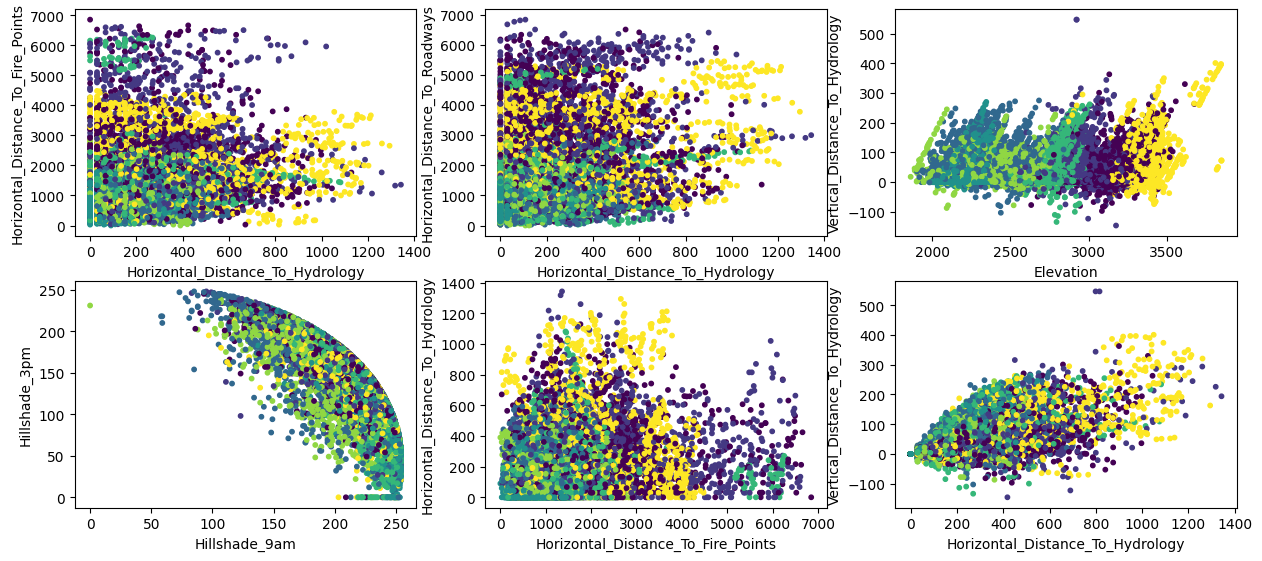

In [16]:
classes = np.array(list(train_data_non_cat.Cover_Type.values))

def plotRelation(first_feature, sec_feature):
    
    plt.scatter(first_feature, sec_feature, c = classes, s=10)
    plt.xlabel(first_feature.name)
    plt.ylabel(sec_feature.name)
    
f = plt.figure(figsize=(15,10))
f.add_subplot(331)
plotRelation(train_data_non_cat.Horizontal_Distance_To_Hydrology, train_data_non_cat.Horizontal_Distance_To_Fire_Points)
f.add_subplot(332)
plotRelation(train_data_non_cat.Horizontal_Distance_To_Hydrology, train_data_non_cat.Horizontal_Distance_To_Roadways)
f.add_subplot(333)
plotRelation(train_data_non_cat.Elevation, train_data_non_cat.Vertical_Distance_To_Hydrology)
f.add_subplot(334)
plotRelation(train_data_non_cat.Hillshade_9am, train_data_non_cat.Hillshade_3pm)
f.add_subplot(335)
plotRelation(train_data_non_cat.Horizontal_Distance_To_Fire_Points, train_data_non_cat.Horizontal_Distance_To_Hydrology)
f.add_subplot(336)
plotRelation(train_data_non_cat.Horizontal_Distance_To_Hydrology, train_data_non_cat.Vertical_Distance_To_Hydrology)

Let's see the class counts

In [17]:
train_data.Cover_Type.value_counts()

Cover_Type
4    1744
0    1739
2    1732
5    1728
1    1722
6    1720
3    1711
Name: count, dtype: int64

The data seems perfectly balanced so no need to upsamble, downsample or alter the class weights.

From the above graphs, it seems that some features have clear seperation of classes when combined with other features in this bi-varriate analysis, Now I will try model based feature importtance using ExtraTrees (Extreemly Randomized Trees) Classifier.

In [18]:
clf = ExtraTreesClassifier(n_estimators=900, n_jobs=-1, random_state=0)
train_x = train_data.drop(["Cover_Type"], axis = 1)
train_y = train_data["Cover_Type"]
clf.fit(train_x, train_y)

imp = clf.feature_importances_

df = pd.DataFrame()

df["values"] = imp
df['column'] = list(train_x.columns.values)

df.sort_values(by='values', ascending=False, inplace = True)
df

values                              column
0   0.158666                           Elevation
5   0.078705     Horizontal_Distance_To_Roadways
9   0.065699  Horizontal_Distance_To_Fire_Points
13  0.059396                    Wilderness_Area4
3   0.059182    Horizontal_Distance_To_Hydrology
4   0.050757      Vertical_Distance_To_Hydrology
1   0.050192                              Aspect
6   0.049859                       Hillshade_9am
8   0.046356                       Hillshade_3pm
7   0.045523                      Hillshade_Noon
2   0.041939                               Slope
23  0.030940                         Soil_Type10
51  0.027091                         Soil_Type38
52  0.024073                         Soil_Type39
16  0.022156                          Soil_Type3
10  0.020759                    Wilderness_Area1
12  0.019959                    Wilderness_Area3
17  0.016253                          Soil_Type4
53  0.015046                         Soil_Type40
43  0.012017                         Soil_Type30
15  0.009725                          Soil_Type2
30  0.009451                         Soil_Type17
26  0.008323                         Soil_Type13
35  0.008003                         Soil_Type22
36  0.006934                         Soil_Type23
42  0.006831                         Soil_Type29
25  0.006152                         Soil_Type12
45  0.005718                         Soil_Type32
24  0.004681                         Soil_Type11
46  0.004435                         Soil_Type33
19  0.004271                          Soil_Type6
11  0.004086                    Wilderness_Area2
37  0.003904                         Soil_Type24
48  0.003790                         Soil_Type35
44  0.003408                         Soil_Type31
33  0.002477                         Soil_Type20
14  0.002197                          Soil_Type1
27  0.001774                         Soil_Type14
18  0.001731                          Soil_Type5
29  0.001617                         Soil_Type16
50  0.001232                         Soil_Type37
31  0.001191                         Soil_Type18
32  0.000785                         Soil_Type19
39  0.000775                         Soil_Type26
47  0.000461                         Soil_Type34
34  0.000402                         Soil_Type21
40  0.000316                         Soil_Type27
22  0.000235                          Soil_Type9
41  0.000235                         Soil_Type28
49  0.000233                         Soil_Type36
38  0.000044                         Soil_Type25
21  0.000016                          Soil_Type8
20  0.000000                          Soil_Type7
28  0.000000                         Soil_Type15

Now we can confirm that Soil_Type (25, 8, 7, 15) are actually not usefull as stated above

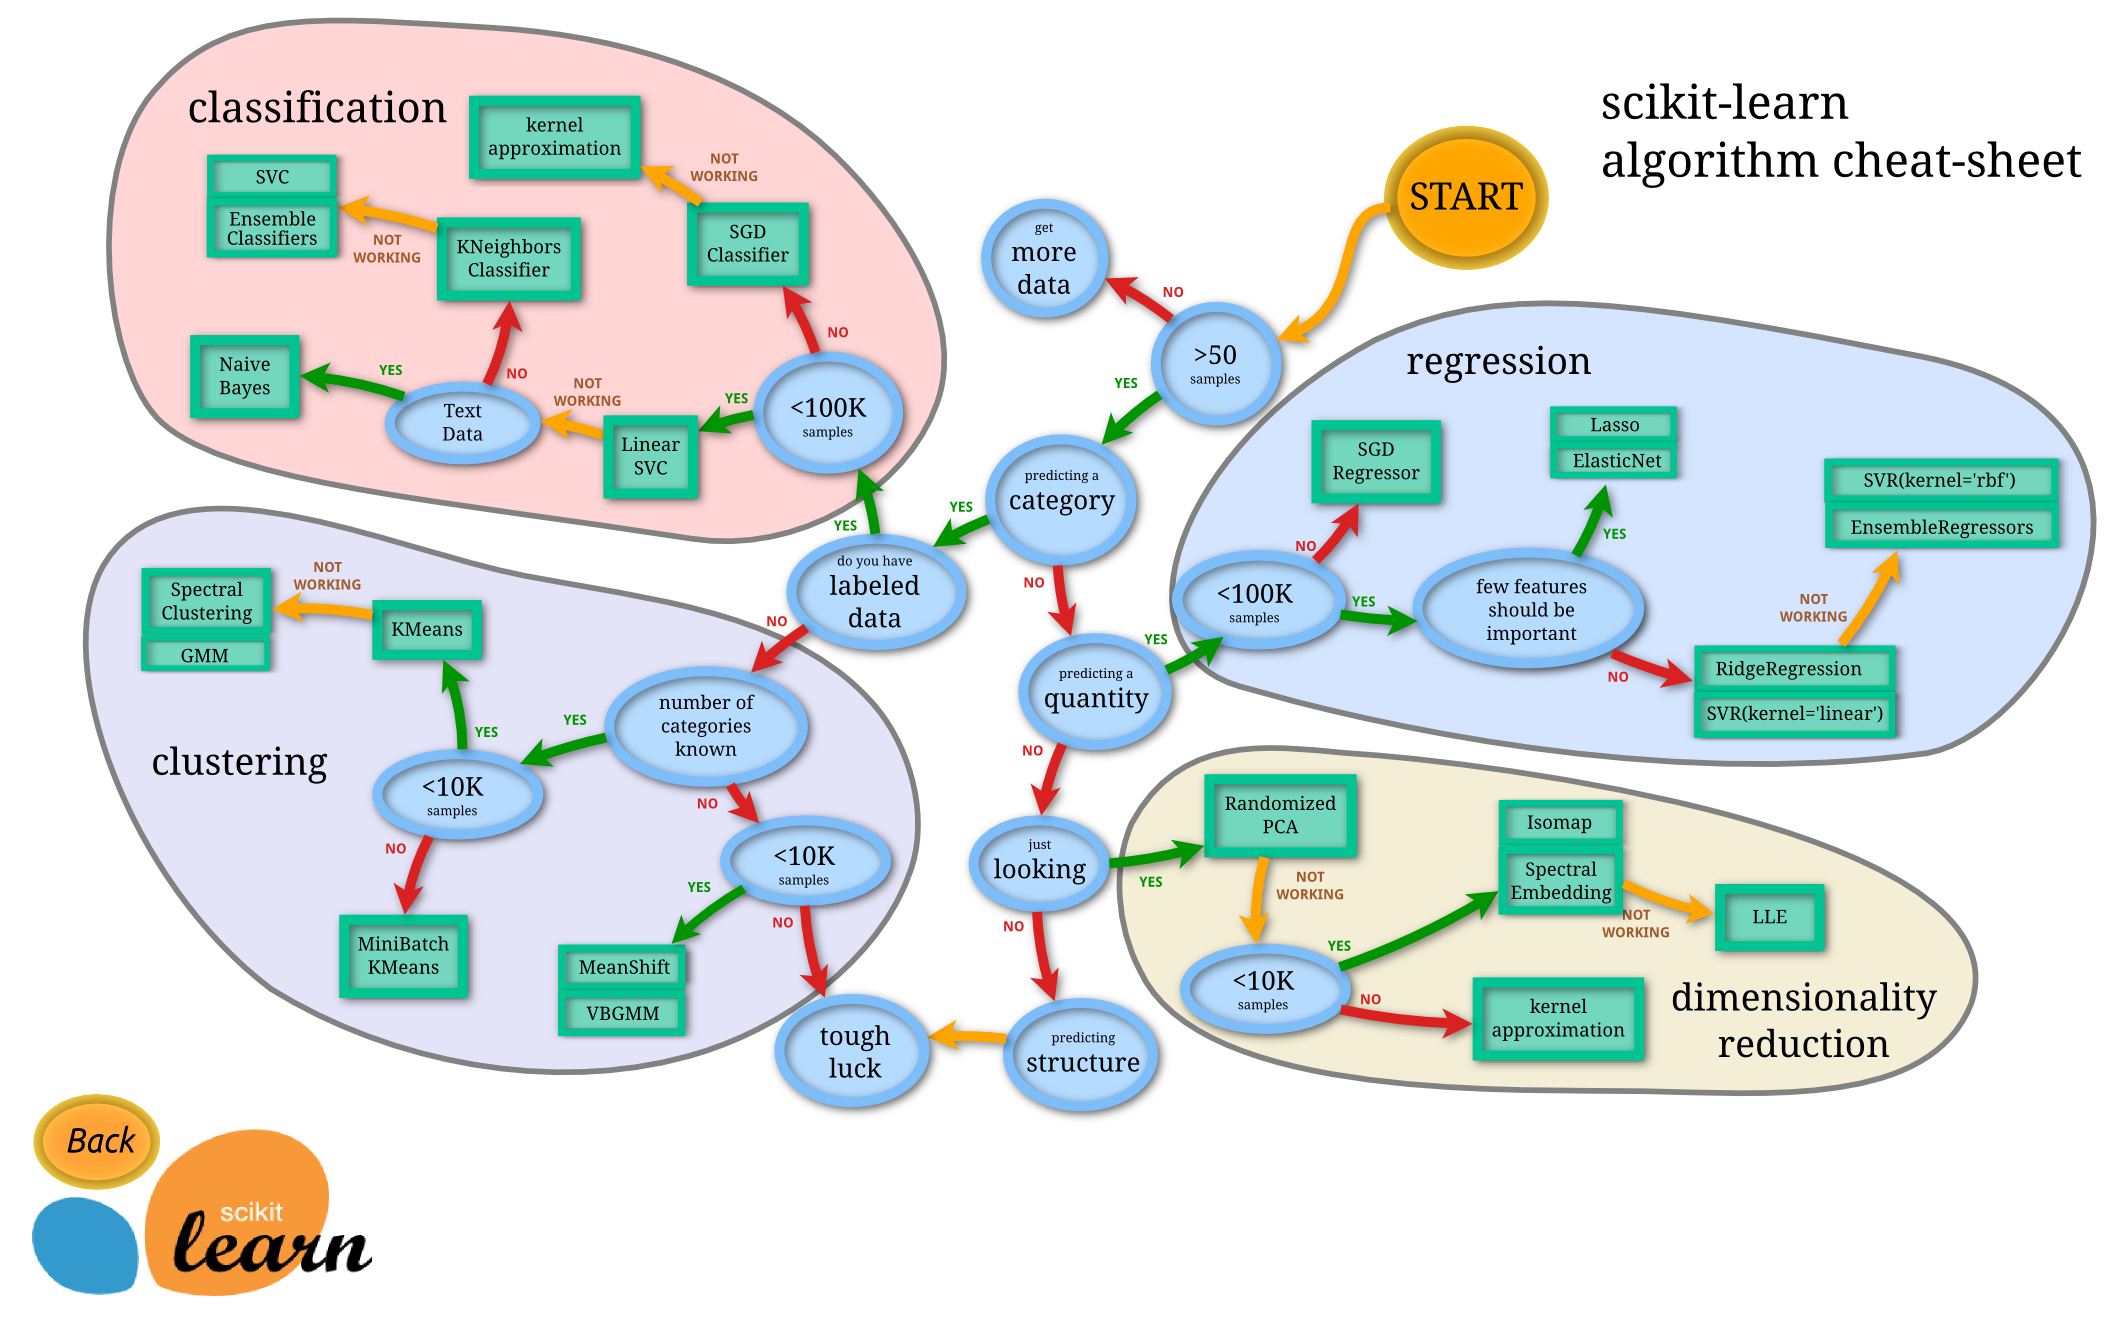

In [21]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()

model.fit(x_train, y_train)

preds = model.predict(x_test)
cross_val_scores = cross_val_score(model, x_train, y_train, cv=10, n_jobs=-1, scoring='accuracy')
conf = confusion_matrix(y_test, preds)

0.4790809972041644


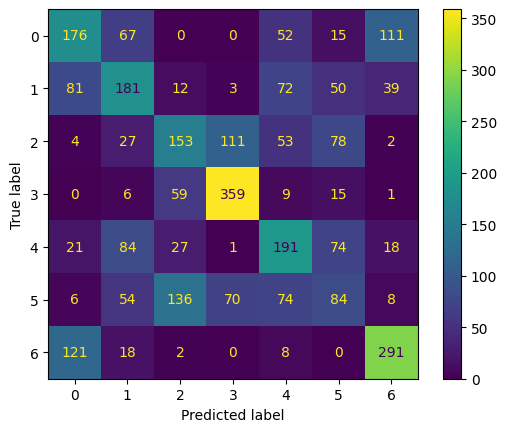

In [22]:
from sklearn.metrics import ConfusionMatrixDisplay

print(cross_val_scores.mean())

disp = ConfusionMatrixDisplay(conf)
disp.plot()

[I 2024-02-25 17:15:51,178] A new study created in memory with name: no-name-79a48f75-6ac8-4dbb-8e92-9a31963f0f6e
[I 2024-02-25 17:16:07,768] Trial 0 finished with value: 0.8140495867768595 and parameters: {'max_depth': 2, 'learning_rate': 0.3328717169382224, 'n_estimators': 2514, 'reg_alpha': 1.2298348918527089e-05, 'reg_lambda': 7.373873929207021e-07}. Best is trial 0 with value: 0.8140495867768595.
[I 2024-02-25 17:19:01,485] Trial 1 finished with value: 0.8293388429752067 and parameters: {'max_depth': 4, 'learning_rate': 0.011746637996506245, 'n_estimators': 3611, 'reg_alpha': 0.0006316151160239429, 'reg_lambda': 1.604724456980205e-08}. Best is trial 1 with value: 0.8293388429752067.
[I 2024-02-25 17:19:34,417] Trial 2 finished with value: 0.8603305785123967 and parameters: {'max_depth': 5, 'learning_rate': 0.10052039857920415, 'n_estimators': 824, 'reg_alpha': 0.0008447856068191063, 'reg_lambda': 1.574774015948992e-07}. Best is trial 2 with value: 0.8603305785123967.
[I 2024-02-25

Number of finished trials: 10
Best trial: {'max_depth': 5, 'learning_rate': 0.10052039857920415, 'n_estimators': 824, 'reg_alpha': 0.0008447856068191063, 'reg_lambda': 1.574774015948992e-07}
0.85 accuracy with a standard deviation of 0.01


<module 'modeling' from 'c:\\Users\\almog\\repos\\Machine_Learning_Course\\modeling.py'>

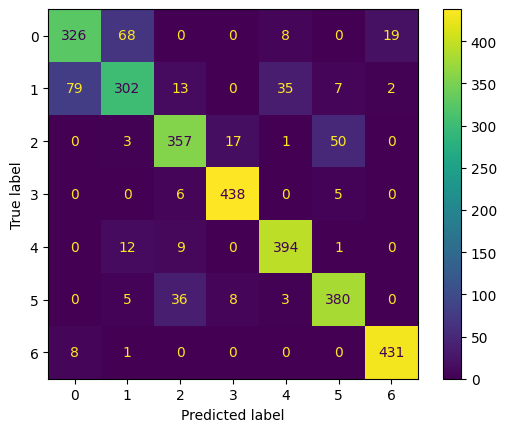

In [73]:
opt = modeling.optimizer(x_train, y_train, x_test, y_test, 10, "gb")
model, val_acc, cross_val_scores, confusion_matrix_ = opt.train_best()

from sklearn.metrics import ConfusionMatrixDisplay
print("%0.2f accuracy with a standard deviation of %0.2f" % (cross_val_scores.mean(), cross_val_scores.std()))
disp = ConfusionMatrixDisplay(confusion_matrix_)
disp.plot()
importlib.reload(modeling)

[I 2024-02-25 17:24:30,805] A new study created in memory with name: no-name-90300ade-ac9a-402f-83b6-262b1ed14fe7
[I 2024-02-25 17:25:06,348] Trial 0 finished with value: 0.6446280991735537 and parameters: {'min_samples_split': 2, 'n_estimators': 4449, 'max_depth': 9, 'max_leaf_nodes': 15, 'bootstrap': True}. Best is trial 0 with value: 0.6446280991735537.
[I 2024-02-25 17:25:13,608] Trial 1 finished with value: 0.6553719008264463 and parameters: {'min_samples_split': 10, 'n_estimators': 860, 'max_depth': 10, 'max_leaf_nodes': 22, 'bootstrap': True}. Best is trial 1 with value: 0.6553719008264463.
[I 2024-02-25 17:25:25,129] Trial 2 finished with value: 0.6338842975206611 and parameters: {'min_samples_split': 10, 'n_estimators': 1342, 'max_depth': 14, 'max_leaf_nodes': 19, 'bootstrap': True}. Best is trial 1 with value: 0.6553719008264463.
[I 2024-02-25 17:25:35,409] Trial 3 finished with value: 0.5900826446280992 and parameters: {'min_samples_split': 3, 'n_estimators': 1444, 'max_dept

Number of finished trials: 10
Best trial: {'min_samples_split': 6, 'n_estimators': 614, 'max_depth': 6, 'max_leaf_nodes': 20, 'bootstrap': True}
0.65 accuracy with a standard deviation of 0.01


<module 'modeling' from 'c:\\Users\\almog\\repos\\Machine_Learning_Course\\modeling.py'>

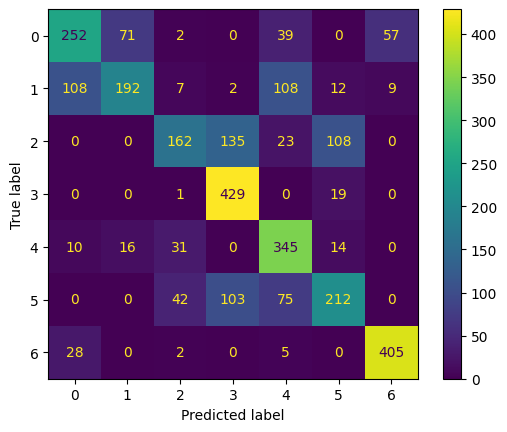

In [74]:
opt = modeling.optimizer(x_train, y_train, x_test, y_test, 10, "et")
model, val_acc, cross_val_scores, confusion_matrix_ = opt.train_best()

from sklearn.metrics import ConfusionMatrixDisplay
print("%0.2f accuracy with a standard deviation of %0.2f" % (cross_val_scores.mean(), cross_val_scores.std()))
disp = ConfusionMatrixDisplay(confusion_matrix_)
disp.plot()
importlib.reload(modeling)

[I 2024-02-25 17:27:33,099] A new study created in memory with name: no-name-eaab2654-04df-4c2e-b989-af9b4fe0ccb5
[I 2024-02-25 17:27:45,453] Trial 0 finished with value: 0.5173553719008265 and parameters: {'n_estimators': 2002, 'max_depth': 1, 'min_samples_split': 18, 'min_samples_leaf': 10, 'bootstrap': True}. Best is trial 0 with value: 0.5173553719008265.
[I 2024-02-25 17:28:14,526] Trial 1 finished with value: 0.6991735537190082 and parameters: {'n_estimators': 2553, 'max_depth': 6, 'min_samples_split': 17, 'min_samples_leaf': 15, 'bootstrap': True}. Best is trial 1 with value: 0.6991735537190082.
[I 2024-02-25 17:28:25,271] Trial 2 finished with value: 0.7628099173553718 and parameters: {'n_estimators': 790, 'max_depth': 8, 'min_samples_split': 17, 'min_samples_leaf': 5, 'bootstrap': True}. Best is trial 2 with value: 0.7628099173553718.
[I 2024-02-25 17:28:26,769] Trial 3 finished with value: 0.728099173553719 and parameters: {'n_estimators': 109, 'max_depth': 7, 'min_samples_sp

Number of finished trials: 10
Best trial: {'n_estimators': 4259, 'max_depth': 14, 'min_samples_split': 9, 'min_samples_leaf': 2, 'bootstrap': True}
0.82 accuracy with a standard deviation of 0.01


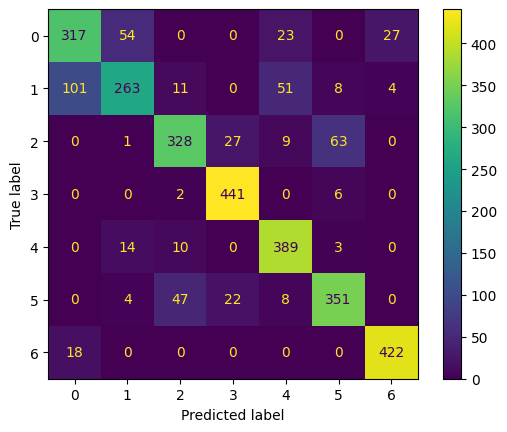

In [75]:
opt = modeling.optimizer(x_train, y_train, x_test, y_test, 10, "rf")
model, val_acc, cross_val_scores, confusion_matrix_ = opt.train_best()

from sklearn.metrics import ConfusionMatrixDisplay
print("%0.2f accuracy with a standard deviation of %0.2f" % (cross_val_scores.mean(), cross_val_scores.std()))
disp = ConfusionMatrixDisplay(confusion_matrix_)
disp.plot()

In [16]:
# sclf = pd.DataFrame({'Id': id, 'Cover_Type': pred})
# sclf.to_csv('submission.csv', index=False)

In [78]:
bet_rf = {'min_samples_split': 6, 'n_estimators': 614, 'max_depth': 6, 'max_leaf_nodes': 20, 'bootstrap': True}
best_et =  {'n_estimators': 4259, 'max_depth': 14, 'min_samples_split': 9, 'min_samples_leaf': 2, 'bootstrap': True}

best_gb = {'max_depth': 5, 'learning_rate': 0.10052039857920415, 'n_estimators': 824, 'reg_alpha': 0.0008447856068191063, 'reg_lambda': 1.574774015948992e-07}

In [18]:
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import StackingClassifier

In [80]:
from sklearn.svm import LinearSVC
from mlxtend.classifier import StackingCVClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

c1 = ExtraTreesClassifier(**best_et) 
c2= RandomForestClassifier(**bet_rf)
c3=XGBClassifier(**best_gb);
meta = LogisticRegression()
sclf = StackingCVClassifier(classifiers=[c1,c2,c3],use_probas=True,meta_classifier=meta, cv = 5)

In [81]:
sclf.fit(x_train, y_train)
print('Accuracy of classifier on training saet: {:.2f}'.format(sclf.score(x_train, y_train) * 100))
print('Accuracy of classifier on test set: {:.2f}'.format(sclf.score(x_test, y_test) * 100))

Accuracy of classifier on training saet: 99.92
Accuracy of classifier on test set: 86.84


In [ ]:
# Cited from https://rasbt.github.io/mlxtend/user_guide/classifier/StackingCVClassifier/#example-3-stacked-cv-classification-and-gridsearch

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

y_score = sclf.predict_proba(x_test)
y = label_binarize(y_test, classes=[0, 1, 2, 3, 4, 5, 6])
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(7):
    fpr[i], tpr[i], _ = roc_curve(y[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label = "random_classifier")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend()
plt.show()

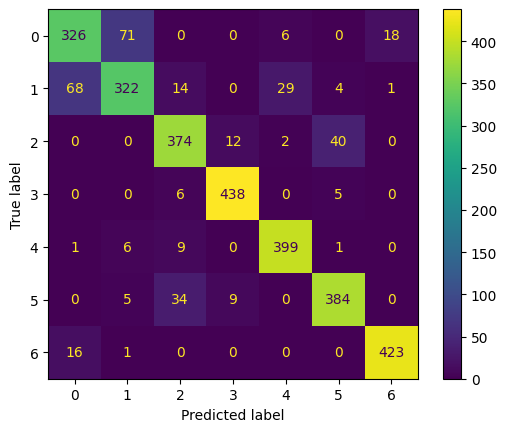

In [64]:
pred = sclf.predict(x_test)
confusion_matrix_ = confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(confusion_matrix_)
disp.plot()

In [101]:
x_train.shape

(12096, 50)

In [109]:
from sklearn.decomposition import PCA

pca = PCA(n_components=15)
x_train_reduced = pca.fit_transform(x_train)
x_test_reduced = pca.transform(x_test)

[I 2024-02-29 14:41:11,815] A new study created in memory with name: no-name-12957fdc-96a6-47ce-bd21-6c42359ef26f


[I 2024-02-29 14:42:19,280] Trial 0 finished with value: 0.8665289256198347 and parameters: {'max_depth': 6, 'learning_rate': 0.039662399167347484, 'n_estimators': 1686, 'reg_alpha': 0.00010781836052281512, 'reg_lambda': 7.499531163007604e-07}. Best is trial 0 with value: 0.8665289256198347.
[I 2024-02-29 14:42:31,061] Trial 1 finished with value: 0.8347107438016529 and parameters: {'max_depth': 3, 'learning_rate': 0.4348274174964851, 'n_estimators': 4422, 'reg_alpha': 0.037289139016112506, 'reg_lambda': 1.9243944465169592e-07}. Best is trial 0 with value: 0.8665289256198347.
[I 2024-02-29 14:42:41,872] Trial 2 finished with value: 0.8392561983471074 and parameters: {'max_depth': 4, 'learning_rate': 0.4742687107585836, 'n_estimators': 2373, 'reg_alpha': 2.2389659087660546e-06, 'reg_lambda': 1.5198672246476915e-05}. Best is trial 0 with value: 0.8665289256198347.
[I 2024-02-29 14:45:18,889] Trial 3 finished with value: 0.8648760330578512 and parameters: {'max_depth': 8, 'learning_rate':

Number of finished trials: 15
Best trial: {'max_depth': 6, 'learning_rate': 0.039662399167347484, 'n_estimators': 1686, 'reg_alpha': 0.00010781836052281512, 'reg_lambda': 7.499531163007604e-07}
0.86 accuracy with a standard deviation of 0.01


<module 'modeling' from 'c:\\Users\\almog\\repos\\Machine_Learning_Course\\modeling.py'>

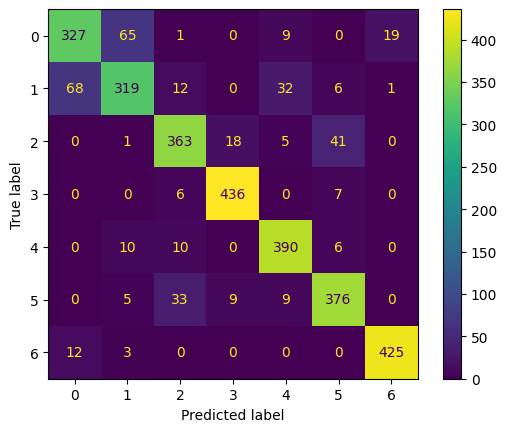

In [110]:
opt = modeling.optimizer(x_train_reduced, y_train, x_test_reduced, y_test, 15, "gb")
model, val_acc, cross_val_scores, confusion_matrix_ = opt.train_best()

from sklearn.metrics import ConfusionMatrixDisplay
print("%0.2f accuracy with a standard deviation of %0.2f" % (cross_val_scores.mean(), cross_val_scores.std()))
disp = ConfusionMatrixDisplay(confusion_matrix_)
disp.plot()
importlib.reload(modeling)

[I 2024-02-29 15:40:04,934] A new study created in memory with name: no-name-de5a0b93-799e-4dd5-bea1-6663445c6da4


[I 2024-02-29 15:40:24,078] Trial 0 finished with value: 0.6334710743801653 and parameters: {'min_samples_split': 9, 'n_estimators': 1030, 'max_depth': 15, 'max_leaf_nodes': 21, 'bootstrap': True}. Best is trial 0 with value: 0.6334710743801653.
[I 2024-02-29 15:41:27,613] Trial 1 finished with value: 0.6446280991735537 and parameters: {'min_samples_split': 6, 'n_estimators': 4236, 'max_depth': 11, 'max_leaf_nodes': 20, 'bootstrap': True}. Best is trial 1 with value: 0.6446280991735537.
[I 2024-02-29 15:41:37,318] Trial 2 finished with value: 0.6111570247933884 and parameters: {'min_samples_split': 9, 'n_estimators': 674, 'max_depth': 9, 'max_leaf_nodes': 16, 'bootstrap': True}. Best is trial 1 with value: 0.6446280991735537.
[I 2024-02-29 15:42:10,219] Trial 3 finished with value: 0.6165289256198347 and parameters: {'min_samples_split': 2, 'n_estimators': 2321, 'max_depth': 11, 'max_leaf_nodes': 16, 'bootstrap': True}. Best is trial 1 with value: 0.6446280991735537.
[I 2024-02-29 15:4

Number of finished trials: 10
Best trial: {'min_samples_split': 6, 'n_estimators': 4236, 'max_depth': 11, 'max_leaf_nodes': 20, 'bootstrap': True}
0.64 accuracy with a standard deviation of 0.01


<module 'modeling' from 'c:\\Users\\almog\\repos\\Machine_Learning_Course\\modeling.py'>

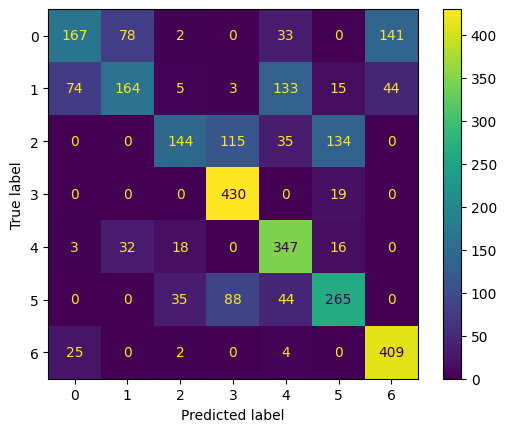

In [116]:
opt = modeling.optimizer(x_train_reduced, y_train, x_test_reduced, y_test, 10, "et")
model, val_acc, cross_val_scores, confusion_matrix_ = opt.train_best()

from sklearn.metrics import ConfusionMatrixDisplay
print("%0.2f accuracy with a standard deviation of %0.2f" % (cross_val_scores.mean(), cross_val_scores.std()))
disp = ConfusionMatrixDisplay(confusion_matrix_)
disp.plot()
importlib.reload(modeling)

[I 2024-02-29 15:47:19,177] A new study created in memory with name: no-name-e2360ad6-ec30-4f66-afc6-b738bad9c6c7
[I 2024-02-29 15:49:20,533] Trial 0 finished with value: 0.7619834710743801 and parameters: {'n_estimators': 3546, 'max_depth': 8, 'min_samples_split': 17, 'min_samples_leaf': 13, 'bootstrap': True}. Best is trial 0 with value: 0.7619834710743801.
[I 2024-02-29 15:49:58,027] Trial 1 finished with value: 0.7475206611570248 and parameters: {'n_estimators': 1158, 'max_depth': 8, 'min_samples_split': 13, 'min_samples_leaf': 9, 'bootstrap': True}. Best is trial 0 with value: 0.7619834710743801.
[I 2024-02-29 15:52:38,950] Trial 2 finished with value: 0.8334710743801653 and parameters: {'n_estimators': 2981, 'max_depth': 13, 'min_samples_split': 10, 'min_samples_leaf': 1, 'bootstrap': True}. Best is trial 2 with value: 0.8334710743801653.
[I 2024-02-29 15:54:32,346] Trial 3 finished with value: 0.6351239669421488 and parameters: {'n_estimators': 4779, 'max_depth': 4, 'min_samples

Number of finished trials: 10
Best trial: {'n_estimators': 2981, 'max_depth': 13, 'min_samples_split': 10, 'min_samples_leaf': 1, 'bootstrap': True}
0.82 accuracy with a standard deviation of 0.01


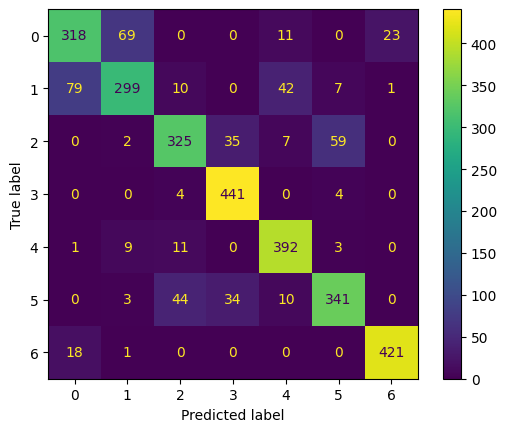

In [117]:
opt = modeling.optimizer(x_train_reduced, y_train, x_test_reduced, y_test, 10, "rf")
model, val_acc, cross_val_scores, confusion_matrix_ = opt.train_best()

from sklearn.metrics import ConfusionMatrixDisplay
print("%0.2f accuracy with a standard deviation of %0.2f" % (cross_val_scores.mean(), cross_val_scores.std()))
disp = ConfusionMatrixDisplay(confusion_matrix_)
disp.plot()

In [119]:
bet_rf = {'n_estimators': 2981, 'max_depth': 13, 'min_samples_split': 10, 'min_samples_leaf': 1, 'bootstrap': True}
best_et =  {'min_samples_split': 6, 'n_estimators': 4236, 'max_depth': 11, 'max_leaf_nodes': 20, 'bootstrap': True}

best_gb = {'max_depth': 6, 'learning_rate': 0.039662399167347484, 'n_estimators': 1686, 'reg_alpha': 0.00010781836052281512, 'reg_lambda': 7.499531163007604e-07}

In [120]:
from sklearn.svm import LinearSVC
from mlxtend.classifier import StackingCVClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

c1 = ExtraTreesClassifier(**best_et) 
c2= RandomForestClassifier(**bet_rf)
c3=XGBClassifier(**best_gb);
meta = LogisticRegression()
sclf = StackingCVClassifier(classifiers=[c1,c2,c3],use_probas=True,meta_classifier=meta, cv = 5)

In [122]:
sclf.fit(x_train_reduced, y_train)
print('Accuracy of classifier on training saet: {:.2f}'.format(sclf.score(x_train_reduced, y_train) * 100))
print('Accuracy of classifier on test set: {:.2f}'.format(sclf.score(x_test_reduced, y_test) * 100))

Accuracy of classifier on training saet: 99.97
Accuracy of classifier on test set: 87.17


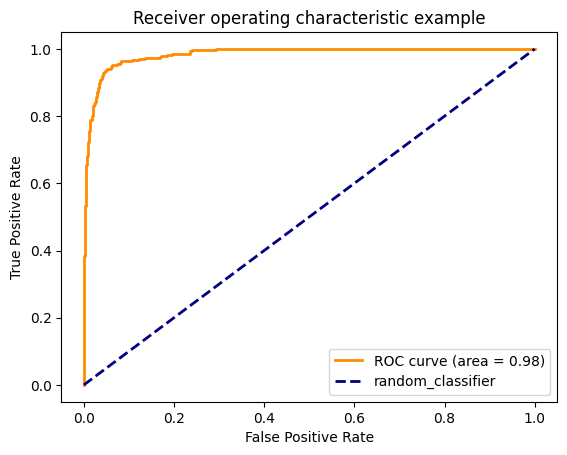

In [162]:
pred = sclf.predict(x_test_reduced)
confusion_matrix_ = confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(confusion_matrix_)
disp.plot()